# Imports - utils

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import to_hex
from matplotlib.lines import Line2D
import seaborn as sns
import os

In [ ]:
if 'google.colab' in str(get_ipython()): # running in colab
    !git clone --config lfs.fetchinclude="*"  https://github.com/sinc-lab/revisiting_crossval_RNAfolding.git
    DATA_PATH = './revisiting_crossval_RNAfolding/'
else:
    DATA_PATH = '../'

In [3]:
def get_tp(bp_x, bp_ref, strict):
    tp = 0
    for rbp in bp_x:
        cond = rbp in bp_ref
        if not strict:
            cond = cond or [rbp[0], rbp[1] - 1] in bp_ref or [rbp[0], rbp[1] + 1] in bp_ref or [rbp[0] + 1, rbp[1]] in bp_ref or [rbp[0] - 1, rbp[1]] in bp_ref
        if cond:
            tp += 1
    return tp

def bp_metrics(ref_bp, pre_bp, strict=True):
    """F1, recall and precision score from base pairs. Is the same as triangular but less efficient. strict=False takes into account the  neighbors for each base pair as correct"""
    assert all([type(bp) == list for bp in ref_bp]), "ref_bp must be a list of lists"
    assert all([type(bp) == list for bp in pre_bp]), "pre_bp must be a list of lists"

    # corner case when there are no positives
    if len(ref_bp) == 0 and len(pre_bp) == 0:
        return 1.0, 1.0, 1.0

    tp1 = get_tp(pre_bp, ref_bp, strict)
    tp2 = get_tp(ref_bp, pre_bp, strict)

    fn = len(ref_bp) - tp1
    fp = len(pre_bp) - tp1

    tpr = pre = f1 = 0.0
    if tp1 + fn > 0:
        tpr = tp1 / float(tp1 + fn)  # sensitivity (=recall =power)
    if tp1 + fp > 0:
        pre = tp2 / float(tp1 + fp)  # precision (=ppv)
    if tpr + pre > 0:
        f1 = 2 * pre * tpr / (pre + tpr)  # F1 score

    return f1, tpr, pre

def dot2bp(struct):
    bp = []
    if not set(struct).issubset(
        set(["."] + [c for par in MATCHING_BRACKETS for c in par])
    ):
        return False

    for brackets in MATCHING_BRACKETS:
        if brackets[0] in struct:
            bpk = fold2bp(struct, brackets[0], brackets[1])
            if bpk:
                bp = bp + bpk
            else:
                return False
    return list(sorted(bp))

VOCABULARY = ["A", "C", "G", "U"]

MATCHING_BRACKETS = [
    ["(", ")"],
    ["[", "]"],
    ["{", "}"],
    ["<", ">"],
    ["A", "a"],
    ["B", "a"],
]

def fold2bp(struc, xop="(", xcl=")"):
    """Get base pairs from one page folding (using only one type of brackets).
    BP are 1-indexed"""
    openxs = []
    bps = []
    if struc.count(xop) != struc.count(xcl):
        return False
    for i, x in enumerate(struc):
        if x == xop:
            openxs.append(i)
        elif x == xcl:
            if len(openxs) > 0:
                bps.append([openxs.pop() + 1, i + 1])
            else:
                return False
    return bps

In [4]:
def strip_folds(summary, splits, x_, hue_, title_, fig_size, palette, include_legend, fam_order=None):

    if fig_size == "1col":
        fig_width1col = 3.22
    elif fig_size == "2col":
        fig_width1col = 6.75
    elif fig_size == "2in2col":
        fig_width1col = 6.75/2
    elif fig_size == "3in2col":
        fig_width1col = 6.75/3
    else:
        fig_width1col = 3.22
        print("fig_size not recognized, using 1col size")
    fig_height = 3.0

    font_size = 6 # max 7
    fig, ax = plt.subplots(figsize=(fig_width1col, fig_height), dpi=150)
    plt.rcParams.update({'font.size': font_size})
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    # ====

    if fam_order is None:
      test = splits.loc[splits['partition']=='test'].groupby(['fold_number']).count()
      train = splits.loc[splits['partition']=='train'].groupby(['fold_number']).count()
    else:
      test = splits.loc[splits['partition']=='test'].groupby(['fold_name']).count()
      train = splits.loc[splits['partition']=='train'].groupby(['fold_name']).count()
    tt = (test/(test+train))

    sns.stripplot(
        data=summary,
        x= x_,
        y='f1',
        hue= hue_,
        dodge=True,
        palette=palette,
        jitter=0.25,
        alpha=0.15,
        size=2,
        legend=False,
        order=fam_order
    )

    markers = ['o', 's', 'D', 'P', '^', 'v', 'X', 'd', '<', '>']
    marker_colors = ['#5252FF'] * 4 + ['#FF3737'] * 6
    marker_sizes = 0.5 * np.array([35, 30, 30, 45, 50, 50, 50, 50, 50, 50])
    methods = summary.method.unique()
    n_methods = len(methods)
    for i, method in enumerate(methods):
        medians = summary[summary["method"] == method].groupby("fold")["f1"].median().reset_index()
        if fam_order is not None:
            original_order = list(summary.family.unique())
            medians_copy = medians.copy()
            for j, fam in enumerate(fam_order):
                mf1 = medians_copy.loc[medians_copy['fold'] == original_order.index(fam), 'f1'].values[0]
                medians.loc[medians['fold'] == j, 'f1'] = mf1

        offset = (i - (n_methods - 1) / 2) * 0.08
        plt.scatter(
            medians["fold"] + offset,
            medians["f1"],
            color=marker_colors[i],
            label=f"{method}",
            marker=markers[i % len(markers)],
            s=marker_sizes[i],
            edgecolor='black',
            linewidth=0.5,
            zorder=3
        )

    if x_ == "fold": xx='fold_number'
    elif x_ == "family":
      xx=fam_order
      # sort tt with the fam_order
      tt = tt.reindex(fam_order)

    ax = sns.barplot(data=tt, x=xx, y='partition', edgecolor = 'w',
                     facecolor='lightgrey', linewidth=2, err_kws={'color': 'none', 'linewidth': 0})
    for bar in ax.patches:
        x = bar.get_x()
        w = bar.get_width()
        h = bar.get_height()
        plt.plot([x, x + w], [h, h], color='black', linewidth=1)


    if include_legend=='on':
      plt.legend(title="Methods", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=font_size)
    else:
      plt.legend().remove()

    plt.xlabel("Folds", fontsize=font_size)
    plt.ylabel("F1", fontsize=font_size)
    plt.tight_layout()
    plt.ylim(0,1)

    plt.savefig(DATA_PATH + "results/figures/Fig2_"+title_+".pdf", bbox_inches='tight', dpi=300)

# Data

In [5]:
dataset = pd.read_csv(f"{DATA_PATH}data/archiveII.csv", index_col="id")

In [6]:
classical_methods = ["RNAfold", "RNAstructure", "LinearFoldV", "LinearPartitionV", "ProbKnot", "IPKnot"]
trained_methods = ["MxFold2", "REDfold", "UFold", "sincFold"]

In [7]:
palette = ["#6A6AFA", "#6262F8", "#2929FB", "#0000FF",
           "#FF746C", "#FC5141", "#FF2727", "#ED2100", "#FD0A0A", "#D20E00"]

# classical methods

In [8]:
# load predictions and compute f1 scores
classical_summary = []
for method in classical_methods:
    print(method, end=" ")
    pred = pd.read_csv(DATA_PATH+f"predictions/{method}.csv", index_col="id")
    pred["ref"] = dataset.loc[pred.index, "base_pairs"]
    pred[["f1", "rec", "pre"]] = pred.apply(lambda x: bp_metrics(json.loads(x["ref"]), json.loads(x["base_pairs"])), axis=1, result_type="expand")
    pred["method"] = method
    pred = pred[["method", "f1", "rec", "pre"]]
    classical_summary.append(pred)
classical_summary = pd.concat(classical_summary)

RNAfold RNAstructure LinearFoldV LinearPartitionV ProbKnot IPKnot 

# Random k-folds

In [ ]:
partition_name = "random_kfolds"
splits_kfold = pd.read_csv(f"{DATA_PATH}data/{partition_name}_split.csv", index_col="id")
folds = sorted(splits_kfold["fold_number"].unique())
summary_kfold = []
for fold in folds:
    partition_set = splits_kfold[(splits_kfold["fold_number"] == fold) & (splits_kfold["partition"] == "test")]
    print(fold, end=" ")
    for method in trained_methods:
        f = DATA_PATH+f"predictions/{partition_name}/{method}/{fold}/pred.csv"
        if not os.path.exists(f):
            print(f"\n{method, fold} not found, skipping\n")
            continue

        pred = pd.read_csv(f, index_col="id")
        pred["ref"] = dataset.loc[partition_set.index, "base_pairs"]
        pred[["f1", "rec", "pre"]] = pred.apply(lambda x: bp_metrics(json.loads(x["ref"]), json.loads(x["base_pairs"])), axis=1, result_type="expand")
        pred["method"] = method
        pred["fold"] = fold
        pred = pred[["method", "fold", "f1", "rec", "pre"]]
        summary_kfold.append(pred)
summary_kfold = pd.concat(summary_kfold)

0 1 2 3 4 

In [11]:
# add classical methods to kfold summary
for method in classical_methods:
    for fold in folds:
        partition_set = splits_kfold[(splits_kfold["fold_number"] == fold) & (splits_kfold["partition"] == "test")]
        res = classical_summary.loc[partition_set.index]
        res = res[res["method"] == method]
        res["fold"] = fold
        summary_kfold = pd.concat([summary_kfold, res])
summary_kfold.method.unique()

array(['MxFold2', 'REDfold', 'UFold', 'sincFold', 'RNAfold',
       'RNAstructure', 'LinearFoldV', 'LinearPartitionV', 'ProbKnot',
       'IPKnot'], dtype=object)

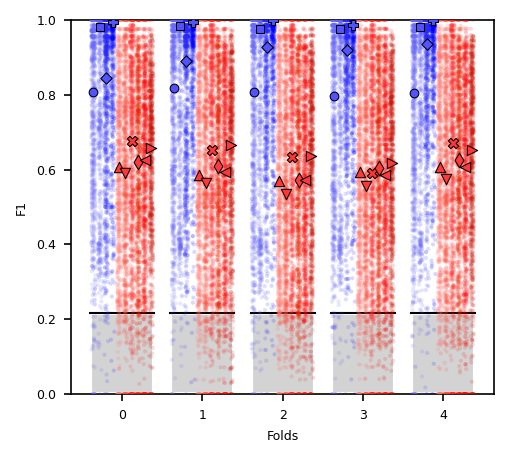

In [12]:
strip_folds(summary_kfold, splits_kfold, "fold", "method", "Random k-folds", "2in2col", palette, "off")

# Clustering folds

In [14]:
partition_name = "clustering_folds"
splits_cfold = pd.read_csv(f"{DATA_PATH}data/{partition_name}_split.csv", index_col="id")

In [15]:
folds = sorted(splits_cfold["fold_number"].unique())
summary_cfold = []
for fold in folds:
    partition_set = splits_cfold[(splits_cfold["fold_number"] == fold) & (splits_cfold["partition"] == "test")]
    print(fold, end=" ")
    for method in trained_methods:
        f = DATA_PATH+f"predictions/{partition_name}/{method}/{fold}/pred.csv"
        if not os.path.exists(f):
            print(f"\n{method, fold} not found, skipping\n")
            continue
        print(method, end=" ")

        pred = pd.read_csv(f, index_col="id")
        pred["ref"] = dataset.loc[partition_set.index, "base_pairs"]
        pred[["f1", "rec", "pre"]] = pred.apply(lambda x: bp_metrics(json.loads(x["ref"]), json.loads(x["base_pairs"])), axis=1, result_type="expand")
        pred["method"] = method
        pred["fold"] = fold
        pred = pred[["method", "fold", "f1", "rec", "pre"]]
        summary_cfold.append(pred)
    print()
summary_cfold = pd.concat(summary_cfold)

0 MxFold2 REDfold UFold sincFold 
1 MxFold2 REDfold UFold sincFold 
2 MxFold2 REDfold UFold sincFold 
3 MxFold2 REDfold UFold sincFold 
4 MxFold2 REDfold UFold sincFold 


In [16]:
# add classical methods to the summary
for method in classical_methods:
    for fold in folds:
        partition_set = splits_cfold[(splits_cfold["fold_number"] == fold) & (splits_cfold["partition"] == "test")]
        res = classical_summary.loc[partition_set.index]
        res = res[res["method"] == method]
        res["fold"] = fold
        summary_cfold = pd.concat([summary_cfold, res])
summary_cfold.method.unique()

array(['MxFold2', 'REDfold', 'UFold', 'sincFold', 'RNAfold',
       'RNAstructure', 'LinearFoldV', 'LinearPartitionV', 'ProbKnot',
       'IPKnot'], dtype=object)

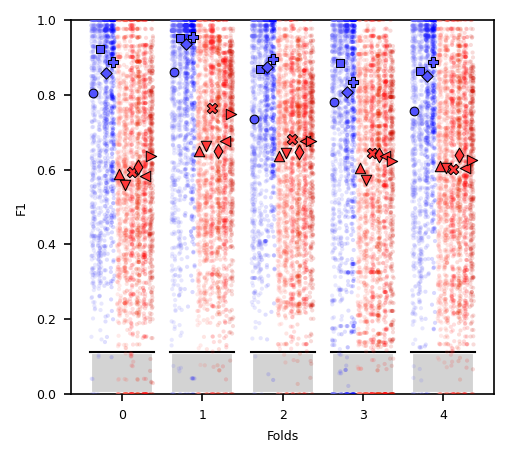

In [17]:
strip_folds(summary_cfold, splits_cfold, "fold", "method", "Clustering fold", "2in2col", palette, "off")

# Family folds

In [20]:
partition_name = "fam_folds"
splits_ffold = pd.read_csv(f"{DATA_PATH}data/{partition_name}_split.csv", index_col="id")

In [22]:
folds = sorted(splits_ffold["fold_number"].unique())
summary_ffold = []
for fold in folds:
    partition_set = splits_ffold[(splits_ffold["fold_number"] == fold) & (splits_ffold["partition"] == "test")]
    print(fold, end=" ")
    for method in trained_methods:
        f = DATA_PATH+f"predictions/{partition_name}/{method}/{fold}/pred.csv"
        if not os.path.exists(f):
            print(f"\n{method, fold} not found, skipping\n")
            continue
        print(method, end=" ")

        pred = pd.read_csv(f, index_col="id")
        pred["ref"] = dataset.loc[partition_set.index, "base_pairs"]
        pred[["f1", "rec", "pre"]] = pred.apply(lambda x: bp_metrics(json.loads(x["ref"]), json.loads(x["base_pairs"])), axis=1, result_type="expand")
        pred["method"] = method
        pred["fold"] = fold
        pred = pred[["method", "fold", "f1", "rec", "pre"]]
        summary_ffold.append(pred)
    print()
summary_ffold = pd.concat(summary_ffold)

0 MxFold2 REDfold UFold sincFold 
1 MxFold2 REDfold UFold sincFold 
2 MxFold2 REDfold UFold sincFold 
3 MxFold2 REDfold UFold sincFold 
4 MxFold2 REDfold UFold sincFold 
5 MxFold2 REDfold UFold sincFold 
6 MxFold2 REDfold UFold sincFold 
7 MxFold2 REDfold UFold sincFold 
8 MxFold2 REDfold UFold sincFold 


In [23]:
# add classical methods to the summary
for method in classical_methods:
    for fold in folds:
        partition_set = splits_ffold[(splits_ffold["fold_number"] == fold) & (splits_ffold["partition"] == "test")]
        res = classical_summary.loc[partition_set.index]
        res = res[res["method"] == method]
        res["fold"] = fold
        summary_ffold = pd.concat([summary_ffold, res])
summary_ffold.method.unique()

array(['MxFold2', 'REDfold', 'UFold', 'sincFold', 'RNAfold',
       'RNAstructure', 'LinearFoldV', 'LinearPartitionV', 'ProbKnot',
       'IPKnot'], dtype=object)

In [24]:
family_name = {n: splits_ffold[splits_ffold.fold_number==n].iloc[0].fold_name for n in sorted(splits_ffold.fold_number.unique())}
summary_ffold["family"] = summary_ffold.fold.apply(lambda x: family_name[x])

In [25]:
sorted_families = ['tRNA', '5s', 'tmRNA', 'RNaseP', 'srp', 'grp1', '23s', '16s', 'telomerase'] # from RNA-LLM paper

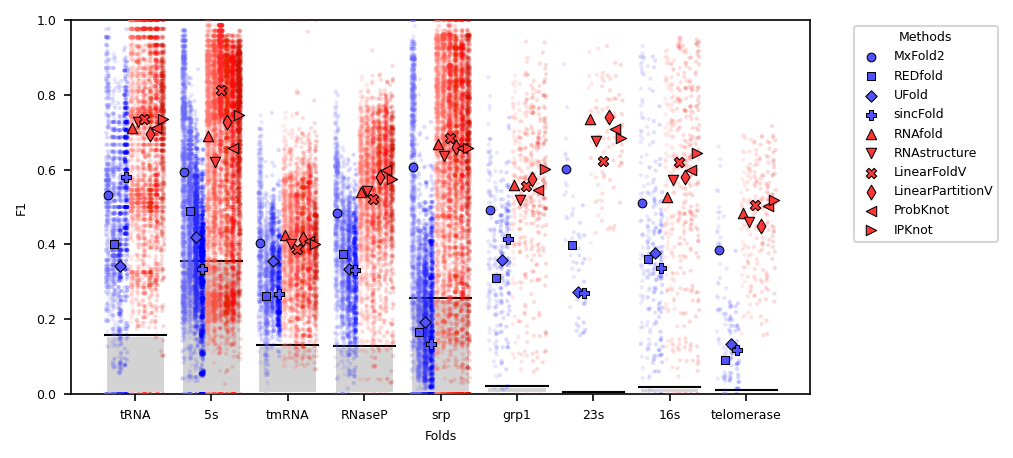

In [26]:
strip_folds(summary_ffold, splits_ffold, "family", "method", "Fam-fold", "2col", palette, "on", sorted_families)

# Human learned folds

In [27]:
partition_name = "hl_folds"
splits_hlfold = pd.read_csv(f"{DATA_PATH}data/{partition_name}_split.csv", index_col="id")

In [28]:
folds =['hl10','hl20','hl30','hl40','hl50','hl60','hl70','hl80','hl90']
summary_hlfold = []
for fold in folds:
    partition_set = splits_hlfold[(splits_hlfold["fold_name"] == fold) & (splits_hlfold["partition"] == "test")]
    print(fold, end=" ")
    for method in trained_methods:
        f = DATA_PATH+f"predictions/{partition_name}/{method}/{fold}/pred.csv"
        if not os.path.exists(f):
            print(f"\n{method, fold} not found, skipping\n")
            continue
        print(method, end=" ")

        pred = pd.read_csv(f, index_col="id")
        pred["ref"] = dataset.loc[partition_set.index, "base_pairs"]
        pred[["f1", "rec", "pre"]] = pred.apply(lambda x: bp_metrics(json.loads(x["ref"]), json.loads(x["base_pairs"])), axis=1, result_type="expand")
        pred["method"] = method
        pred["fold"] = fold
        pred = pred[["method", "fold", "f1", "rec", "pre"]]
        summary_hlfold.append(pred)
    print()
summary_hlfold = pd.concat(summary_hlfold)

hl10 MxFold2 REDfold UFold sincFold 
hl20 MxFold2 REDfold UFold sincFold 
hl30 MxFold2 REDfold UFold sincFold 
hl40 MxFold2 REDfold UFold sincFold 
hl50 MxFold2 REDfold UFold sincFold 
hl60 MxFold2 REDfold UFold sincFold 
hl70 MxFold2 REDfold UFold sincFold 
hl80 MxFold2 REDfold UFold sincFold 
hl90 MxFold2 REDfold UFold sincFold 


In [29]:
# add classical methods to the summary
for method in classical_methods:
    for fold in folds:
        partition_set = splits_hlfold[(splits_hlfold["fold_name"] == fold) & (splits_hlfold["partition"] == "test")]
        res = classical_summary.loc[partition_set.index]
        res = res[res["method"] == method]
        res["fold"] = fold
        summary_hlfold = pd.concat([summary_hlfold, res])
summary_hlfold.method.unique()

array(['MxFold2', 'REDfold', 'UFold', 'sincFold', 'RNAfold',
       'RNAstructure', 'LinearFoldV', 'LinearPartitionV', 'ProbKnot',
       'IPKnot'], dtype=object)

In [30]:
AUCs = {}
wAUCs = {}
for method in summary_hlfold.method.unique():
  wAUC = 0
  AUC = 0
  wacc = 0
  for hl in folds:
      f1mean = summary_hlfold[(summary_hlfold["method"] == method) & (summary_hlfold["fold"] == hl)].f1.mean()
      AUC += f1mean
      w = 1-float(hl[2:])/100
      wAUC += w * f1mean
      wacc += w
      #print(f"{hl}: {f1mean}, {w}")

  AUC /= len(folds)
  wAUC /= wacc

  AUCs[method] = float(AUC)
  wAUCs[method] = float(wAUC)

AUChl = pd.DataFrame([AUCs, wAUCs], index=["AUC", "wAUC"]).T

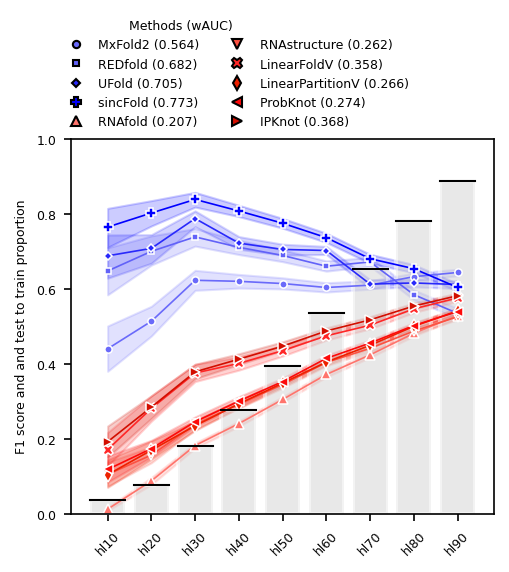

In [31]:
fig_width1col = 6.75/2
fig_height = 3.0
font_size = 6 # max 7
fig, ax = plt.subplots(figsize=(fig_width1col, fig_height), dpi=150)
plt.rcParams.update({'font.size': font_size})
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

mmarkers = ['o', 's', 'D', 'P', '^', 'v', 'X', 'd', '<', '>']
marker_colors = ['#0022B2'] * 4 + ['#D32F2F'] * 6
marker_sizes = 0.1 * np.array([35, 30, 30, 45, 50, 50, 50, 50, 50, 50]) # adjusted for smaller figures

for i, method in enumerate(summary_hlfold.method.unique()):
    sns.lineplot(
        data=summary_hlfold[summary_hlfold["method"] == method],
        x="fold",
        y="f1",
        label=method,
        marker=mmarkers[i],
        markersize=marker_sizes[i],
        color=palette[i],
        linewidth=0.8
    )

test = splits_hlfold.loc[splits_hlfold['partition']=='test'].groupby(['fold_name']).count()
train = splits_hlfold.loc[splits_hlfold['partition']=='train'].groupby(['fold_name']).count()
tt = (test/(test+train))
filtered_folds = [f'hl{i}' for i in range(10, 100, 10)]
tt_filtered = tt[tt.index.isin(filtered_folds)]
ax = sns.barplot(data=tt_filtered, x=tt_filtered.index, y='partition', edgecolor = 'w', facecolor='lightgrey', linewidth=2, err_kws={'color': 'none', 'linewidth': 0}, alpha=0.5, zorder=1)
for bar in ax.patches:
    x = bar.get_x()
    w = bar.get_width()
    h = bar.get_height()
    plt.plot([x, x + w], [h, h], color='black', linewidth=1, zorder=2)


plt.xticks(rotation=45, fontsize=font_size)
plt.ylabel("F1 score and and test to train proportion", fontsize=font_size)
plt.ylim(0,1)
plt.xlabel("")


methods = list(summary_hlfold.method.unique())
handles = []
labels = []
for i, method in enumerate(methods):
    wauc = AUChl.loc[method, "wAUC"] if method in AUChl.index else float("nan")
    labels.append(f"{method} ({wauc:0.3f})")
    handles.append(
        Line2D([0], [0],
                marker=mmarkers[i % len(mmarkers)],
                color='w',
                markerfacecolor=palette[i % len(palette)],
                markeredgecolor='black',
                markersize=marker_sizes[i],
                linestyle='')
    )

    # remove any existing legends
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    for lg in list(fig.legends):
        lg.remove()

    leg = fig.legend(handles, labels, title="Methods (wAUC)", loc='upper left',
                     bbox_to_anchor=(0.1, 1.25), fontsize=font_size, frameon=False, ncol=2)
    leg.set_zorder(10)
    leg.get_title().set_position((-55.5, 0))


plt.tight_layout()

plt.savefig(DATA_PATH + "results/figures/Fig4_HL-folds.pdf", bbox_inches='tight', dpi=300)

# Similarity folds

In [47]:
partition_name = "sim_folds"
splits_sfold = []
for f in os.listdir(f"{DATA_PATH}data/sim_folds_split/"):
    split = pd.read_csv(f"{DATA_PATH}data/sim_folds_split/{f}")
    split["similarity"] = os.path.splitext(f.split("_")[-1].split("-")[0])[0]
    splits_sfold.append(split)
splits_sfold = pd.concat(splits_sfold)

In [51]:
similarities = sorted(splits_sfold["similarity"].unique())
similarities = [os.path.splitext(s)[0] for s in similarities[1:]]
folds = splits_sfold["fold_number"].unique()
summary_sfold = []
for similarity in similarities:
    print(similarity)
    for fold in folds:
        print(fold, end=" ")
        partition_set = splits_sfold[(splits_sfold["fold_number"] == fold) & (splits_sfold["similarity"] == similarity) & (splits_sfold["partition"] == "test")].set_index('id')

        for method in trained_methods:
            f = DATA_PATH+f"predictions/{partition_name}/{method}/{similarity}/{fold}/pred.csv"
            if not os.path.exists(f):
                print(f"\n{method, fold} not found, skipping\n")
                continue
            print(method, end=" ")

            pred = pd.read_csv(f, index_col="id")

            pred["ref"] = dataset.loc[partition_set.index, "base_pairs"]
            pred[["f1", "rec", "pre"]] = pred.apply(lambda x: bp_metrics(json.loads(x["ref"]), json.loads(x["base_pairs"])), axis=1, result_type="expand")
            pred["similarity"] = similarity
            pred["method"] = method
            pred["fold"] = fold
            pred = pred[["method", "similarity", "fold", "f1", "rec", "pre"]]
            summary_sfold.append(pred)
        print()
summary_sfold = pd.concat(summary_sfold)

sim40
0 MxFold2 REDfold UFold sincFold 
1 MxFold2 REDfold UFold sincFold 
2 MxFold2 REDfold UFold sincFold 
3 MxFold2 REDfold UFold sincFold 
4 MxFold2 REDfold UFold sincFold 
5 MxFold2 REDfold UFold sincFold 
6 MxFold2 REDfold UFold sincFold 
7 MxFold2 REDfold UFold sincFold 
8 MxFold2 REDfold UFold sincFold 
9 MxFold2 REDfold UFold sincFold 
sim50
0 MxFold2 REDfold UFold sincFold 
1 MxFold2 REDfold UFold sincFold 
2 MxFold2 REDfold UFold sincFold 
3 MxFold2 REDfold UFold sincFold 
4 MxFold2 REDfold UFold sincFold 
5 MxFold2 REDfold UFold sincFold 
6 MxFold2 REDfold UFold sincFold 
7 MxFold2 REDfold UFold sincFold 
8 MxFold2 REDfold UFold sincFold 
9 MxFold2 REDfold UFold sincFold 
sim60
0 MxFold2 REDfold UFold sincFold 
1 MxFold2 REDfold UFold sincFold 
2 MxFold2 REDfold UFold sincFold 
3 MxFold2 REDfold UFold sincFold 
4 MxFold2 REDfold UFold sincFold 
5 MxFold2 REDfold UFold sincFold 
6 MxFold2 REDfold UFold sincFold 
7 MxFold2 REDfold UFold sincFold 
8 MxFold2 REDfold UFold sincFo

In [52]:
# add classical methods to the summary
for method in classical_methods:
    for similarity in similarities:
      for fold in folds:
        partition_set = splits_sfold[(splits_sfold["fold_number"] == fold) & (splits_sfold["similarity"] == similarity) & (splits_sfold["partition"] == "test")].set_index('id')
        res = classical_summary.loc[partition_set.index]
        res = res[res["method"] == method]
        res["similarity"] = similarity
        res["fold"] = fold
        summary_sfold = pd.concat([summary_sfold, res])
summary_sfold.method.unique()

array(['MxFold2', 'REDfold', 'UFold', 'sincFold', 'RNAfold',
       'RNAstructure', 'LinearFoldV', 'LinearPartitionV', 'ProbKnot',
       'IPKnot'], dtype=object)

In [53]:
AUCs = {}
wAUCs = {}
for method in summary_sfold.method.unique():
  wAUC = 0
  AUC = 0
  wacc = 0
  for similarity in similarities:
      f1mean = summary_sfold[(summary_sfold["method"] == method) & (summary_sfold["similarity"] == similarity)].f1.mean()
      AUC += f1mean
      w = 1-float(similarity[3:])/100
      wAUC += w * f1mean
      wacc += w

  AUC /= len(similarities)
  wAUC /= wacc

  AUCs[method] = float(AUC)
  wAUCs[method] = float(wAUC)

AUCsim = pd.DataFrame([AUCs, wAUCs], index=["AUC", "wAUC"]).T

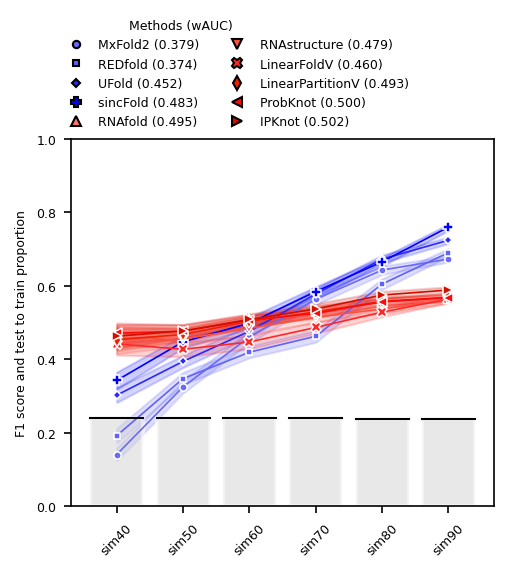

In [54]:
fig_width1col = 6.75/2
fig_height = 3.0
font_size = 6 # max 7
fig, ax = plt.subplots(figsize=(fig_width1col, fig_height), dpi=150)
plt.rcParams.update({'font.size': font_size})
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
mmarkers = ['o', 's', 'D', 'P', '^', 'v', 'X', 'd', '<', '>']
marker_colors = ['#0022B2'] * 4 + ['#D32F2F'] * 6
marker_sizes = 0.1 * np.array([35, 30, 30, 45, 50, 50, 50, 50, 50, 50]) # adjusted for smaller figures

for i, method in enumerate(summary_sfold.method.unique()):
    sns.lineplot(
        data=summary_sfold[summary_sfold["method"] == method],
        x="similarity",
        y="f1",
        label=method,
        marker=mmarkers[i],
        markersize=marker_sizes[i],
        color=palette[i],
        linewidth=0.8
    )

test = splits_sfold.loc[splits_sfold['partition']=='test'].groupby(['similarity']).count()
train = splits_sfold.loc[splits_sfold['partition']=='train'].groupby(['similarity']).count()
tt = (test/(test+train))

tt_filtered = tt[tt.index != 'sim30']
ax = sns.barplot(data=tt_filtered, x=tt_filtered.index, y='partition', edgecolor = 'w', facecolor='lightgrey', linewidth=2, err_kws={'color': 'none', 'linewidth': 0}, alpha=0.5, zorder=1)

for bar in ax.patches:
    x = bar.get_x()
    w = bar.get_width()
    h = bar.get_height()
    plt.plot([x, x + w], [h, h], color='black', linewidth=1, zorder=2)
    plt.tight_layout()


plt.xticks(rotation=45, fontsize=font_size)
plt.ylabel("F1 score and test to train proportion", fontsize=font_size)
plt.ylim(0,1)
plt.xlabel("")

methods = list(summary_sfold.method.unique())
handles = []
labels = []
for i, method in enumerate(methods):
    wauc = AUCsim.loc[method, "wAUC"] if method in AUCsim.index else float("nan")
    labels.append(f"{method} ({wauc:0.3f})")
    handles.append(
        Line2D([0], [0],
               marker=mmarkers[i % len(mmarkers)],
               color='w',
               markerfacecolor=palette[i % len(palette)],
               markeredgecolor='black',
               markersize=marker_sizes[i],
               linestyle='')
    )

if ax.get_legend() is not None:
    ax.get_legend().remove()
for lg in list(fig.legends):
    lg.remove()

leg = fig.legend(handles, labels, title="Methods (wAUC)", loc='upper left',
                    bbox_to_anchor=(0.1, 1.25), fontsize=font_size, frameon=False, ncol=2)
leg.set_zorder(10)
leg.get_title().set_position((-55.5, 0))

plt.tight_layout()

plt.savefig(DATA_PATH + "/results/figures/Fig4_sim-folds.pdf", bbox_inches='tight', dpi=300)